In [32]:
# https://platform.olimpiada-ai.ro/en/problems/70
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
plt.style.use("fivethirtyeight")

In [33]:
train = pd.read_csv("/kaggle/input/abnormal-cardiac/train.csv")
test = pd.read_csv("/kaggle/input/abnormal-cardiac/test.csv")

train.shape, test.shape

((3997, 2), (1000, 1))

In [34]:
train['label'].value_counts(normalize=True)

label
1    0.583938
0    0.416062
Name: proportion, dtype: float64

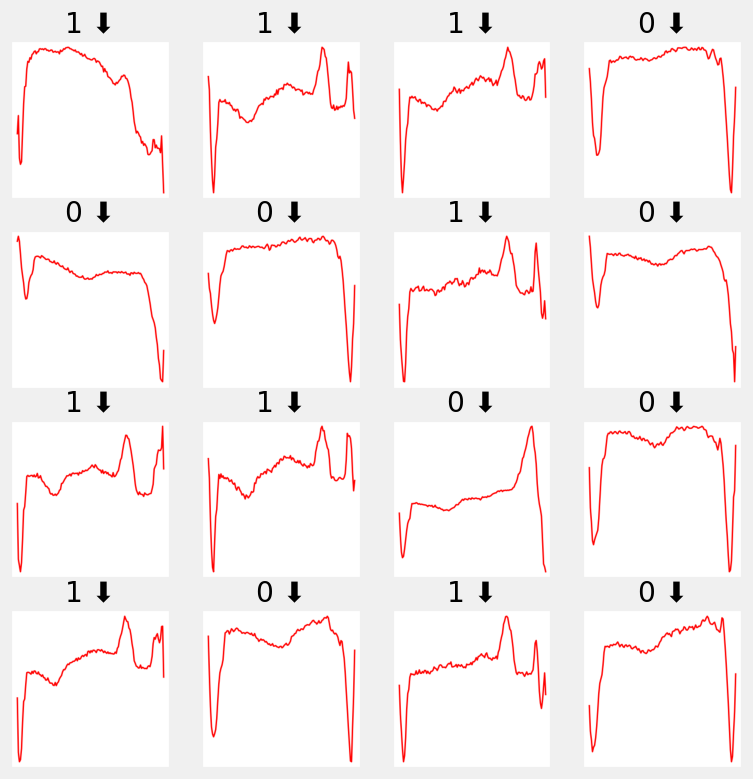

In [35]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9., 9.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.3,
                 )
np.random.seed(4222)
indices = np.random.choice(range(len(train)), size=16, replace=False)

for ax, i in zip(grid, indices):
    ax.imshow(Image.open(os.path.join('/kaggle/input/abnormal-cardiac', train.loc[i, 'image_path'])))
    ax.set_title(f'{train.loc[i, 'label']} ⬇️')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

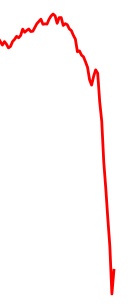

In [36]:
Image.open(os.path.join('/kaggle/input/abnormal-cardiac', train.loc[2, 'image_path'])).crop((182, 0, 310, 308))

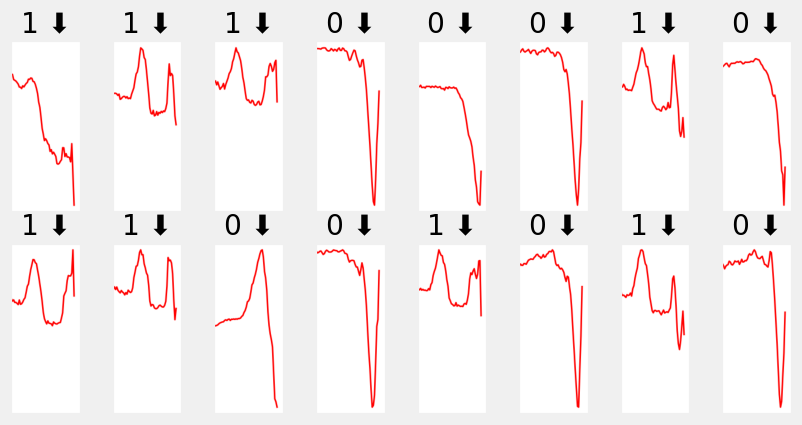

In [37]:
fig = plt.figure(figsize=(9., 9.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 8),
                 axes_pad=0.3,
                 )

for ax, i in zip(grid, indices):
    ax.imshow(Image.open(os.path.join('/kaggle/input/abnormal-cardiac', train.loc[i, 'image_path'])).crop((182, 0, 310, 308)))
    ax.set_title(f'{train.loc[i, 'label']} ⬇️')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [38]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, train_size=0.8, stratify=train['label'], random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((3197, 2), (800, 2))

In [39]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(os.path.join('/kaggle/input/abnormal-cardiac', self.df.loc[idx, 'image_path'])).crop((182, 0, 310, 308))
        if self.transform is not None:
            image = self.transform(image)
        if self.is_test:
            return image
        label = self.df.loc[idx, 'label']
        return image, float(label)

BATCH_SIZE = 64

transform = v2.Compose([
    v2.ToTensor()
])

train_ds = CustomDataset(train, transform)
valid_ds = CustomDataset(valid, transform)
test_ds = CustomDataset(test, transform, is_test=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(50, 13, 16)

In [41]:
next(iter(train_loader))[0].shape

torch.Size([64, 4, 308, 128])

In [42]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=4, classes=1):
        super().__init__()
        
        self.pool = nn.MaxPool2d(2)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*77*32, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, classes)
        )
        
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        return self.fc(x)

model = SimpleCNN().to(device)

In [43]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [44]:
epochs = 3
log_rate = 1

train_losses, valid_losses, valid_accs = [], [], []

for epoch in tqdm(range(epochs), desc='Epoch'):
    model.train()
    i, rloss = 0, 0
    for X, y in (pbar := tqdm(train_loader, desc='Train Loader', leave=False)):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        rloss += loss.item()
        pbar.set_postfix({'loss': f'{rloss/i:.5f}'})

    train_losses.append(rloss/i)
    if (epoch+1)%log_rate==0:
        print(f'Epoch: {epoch+1} | Train Loss: {rloss/i:.5f}')
    
    model.eval()
    i, rloss, rcor, rtot = 0, 0, 0, 0
    for X, y in (pbar := tqdm(valid_loader, desc='Valid Loader', leave=False)):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        with torch.no_grad():
            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            loss = loss_fn(logits, y)

        i += 1
        rloss += loss.item()
        rcor += (preds.squeeze() == y.squeeze()).sum().item()
        rtot += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{rcor/rtot:.5f}'})
    
    valid_losses.append(rloss/i)
    valid_accs.append(rcor/rtot)
    if (epoch+1)%log_rate==0:
        print(f'Valid Loss: {rloss/i:.5f} | Valid Acc: {rcor/rtot:.5f}')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 11.31166


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.98286 | Valid Acc: 0.96125


Train Loader:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.67575


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 1.84347 | Valid Acc: 0.95375


Train Loader:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 0.54886


Valid Loader:   0%|          | 0/13 [00:00<?, ?it/s]

Valid Loss: 0.22992 | Valid Acc: 0.99000


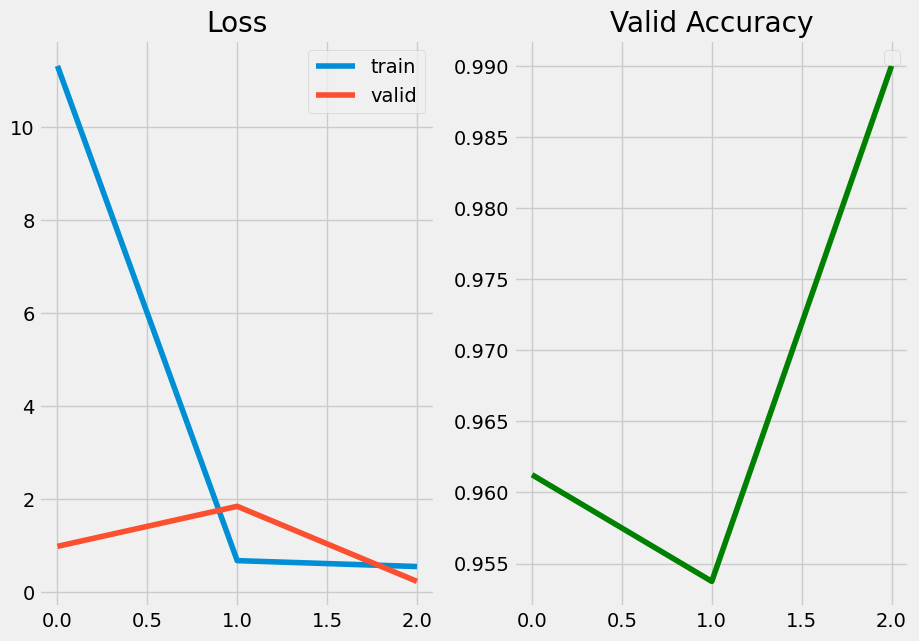

In [45]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(epochs), train_losses, label='train')
plt.plot(range(epochs), valid_losses, label='valid')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Valid Accuracy')
plt.plot(range(epochs), valid_accs, c='green')
plt.legend()

In [46]:
model.eval()
predictions = []
for X in tqdm(test_loader, desc='Test Loader'):
    X = X.to(device)
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        predictions.extend(preds.squeeze().cpu().int().tolist())

Test Loader:   0%|          | 0/16 [00:00<?, ?it/s]

In [47]:
test['label'] = predictions
test.to_csv("submission.csv", index=False)

test['label'].value_counts(normalize=True)

label
1    0.592
0    0.408
Name: proportion, dtype: float64